# IMPORT LIBRARIES

In [148]:
pip install pmdarima

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import pickle
# Google services
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')
from google.auth import default
from google.colab import auth
# Authenticate
auth.authenticate_user()
creds, _ = default()
# Authorize gspread
gc = gspread.authorize(creds)
# Cài đặt hiển thị rộng hơn cho DataFrame
pd.set_option('display.width', 1200)  # Độ rộng tối đa
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD DATA

About Dataset: NMV (Sale) vnd

In [150]:
# Colab
spreadsheet_id = "1R0_tAkBd4w6lR6krI0Zb4Cn1Hc3O_-xygPIE9K_iaZ0"  # Replace with your Spreadsheet ID
sheet_name = "data"  # Change to your sheet name

# Open the Google Spreadsheet
sh = gc.open_by_key(spreadsheet_id)
worksheet = sh.worksheet(sheet_name)

# Get all data
data = worksheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]  # Use first row as headers
df = df[1:]              # Skip the header row in the data

# df['nmv'] = pd.to_numeric(df['nmv']) # Convert 'nmv' column to numeric, handling errors
df['nmv'] = df['nmv'].astype('float')


# Rename columns and keep only Month and Sales
df = df.rename(columns={'date_key': 'Time', 'nmv': 'Sales'})
df = df[['Time', 'Sales']]
df.set_index('Time', inplace=True)
pd.options.display.float_format = '{:,.0f}'.format
print(df)

0                    Sales
Time                      
2023-09-01 196,088,478,048
2023-10-01 193,806,971,443
2023-11-01 185,357,688,406
2023-12-01 169,696,397,949
2024-01-01 148,097,344,016
2024-02-01 101,453,296,824
2024-03-01 132,078,849,895
2024-04-01 104,406,546,191
2024-05-01 114,427,136,014
2024-06-01 105,953,337,425
2024-07-01 126,744,900,165
2024-08-01 139,829,987,390
2024-09-01 138,905,000,000
2024-10-01 134,309,000,000
2024-11-01  99,099,000,000
2024-12-01  94,011,000,000
2025-01-01  76,265,000,000
2025-02-01  72,039,000,000


# EXPLORE DATA ANALYSIS

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 2023-09-01 to 2025-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   18 non-null     float64
dtypes: float64(1)
memory usage: 288.0+ bytes


In [152]:
print(df.describe(include='all'))

0               Sales
count              18
mean  129,587,162,987
std    37,885,939,953
min    72,039,000,000
25%   102,191,609,166
50%   129,411,875,030
75%   146,030,504,860
max   196,088,478,048


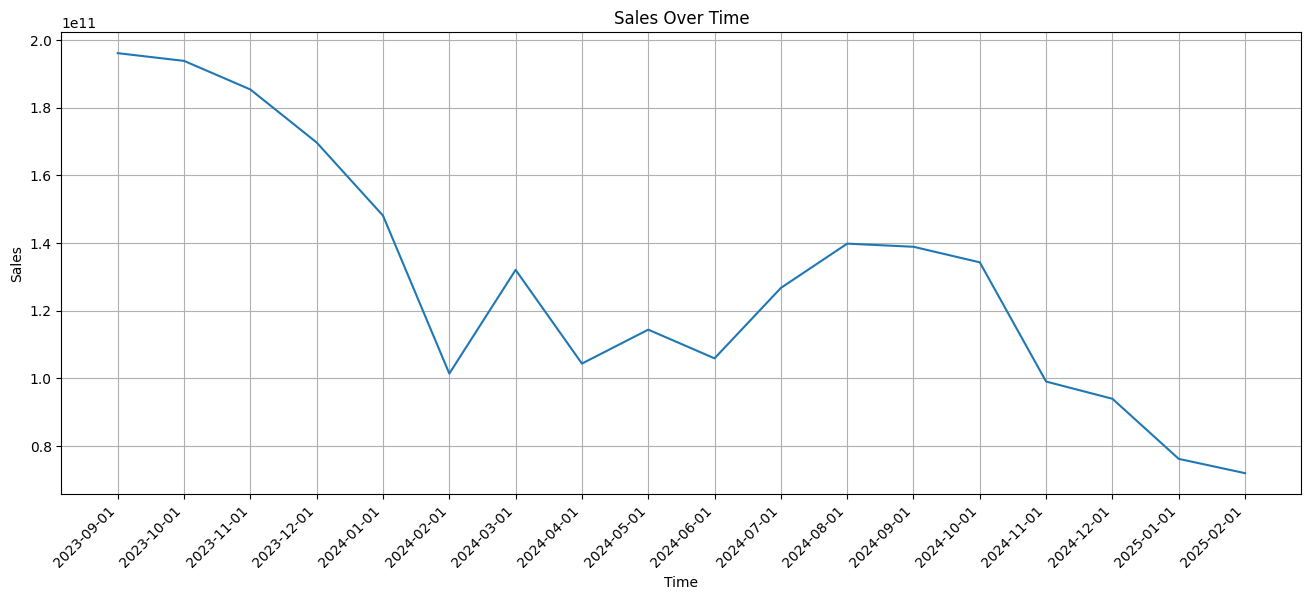

In [153]:
# Plotting the Sales data
plt.figure(figsize=(16, 6))
plt.plot(df['Sales'])
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.grid(True)
plt.xticks(rotation=45, ha='right') # Rotate labels 45 degrees, align right
plt.show()

# INPUT

In [154]:
freq = 4 # input frequency seasonal
lags_1 = 12
lags_2 = 6
time_step = 13 # step time prediction

# SEASONALITY & STATIONATIRY

<ipython-input-155-b5a0856f83fc>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method='ffill')


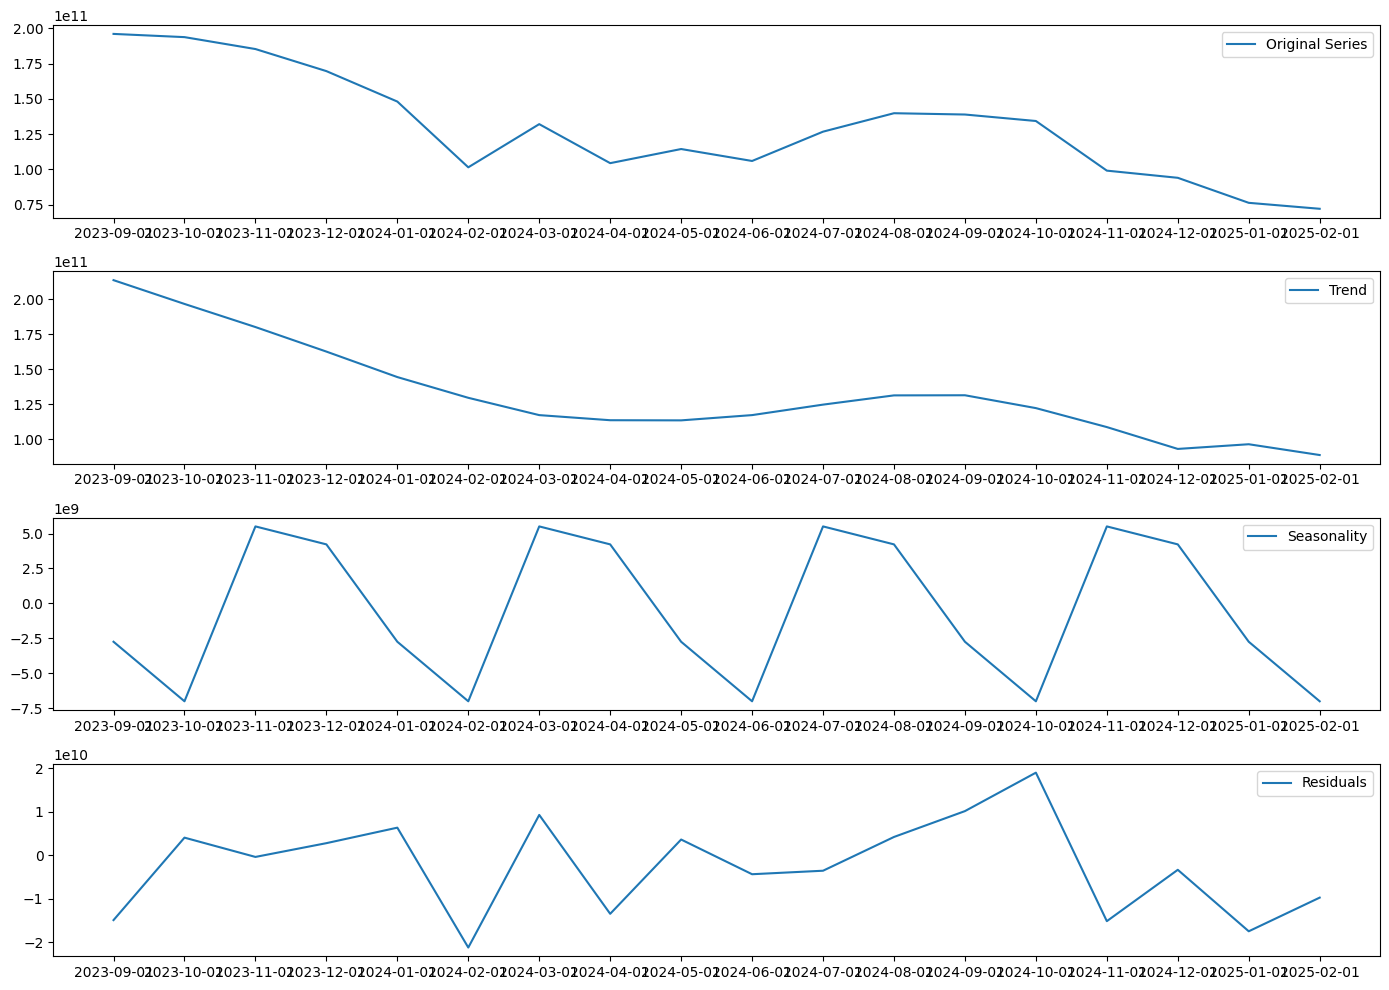


ADF Statistic: -1.9845533853036115
p-value: 0.2933866989368549
Dữ liệu có tính dừng



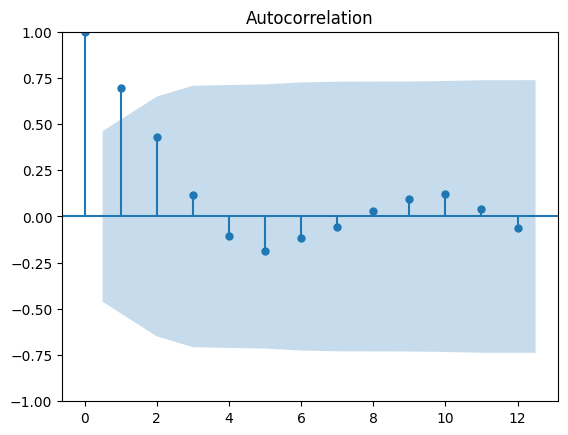

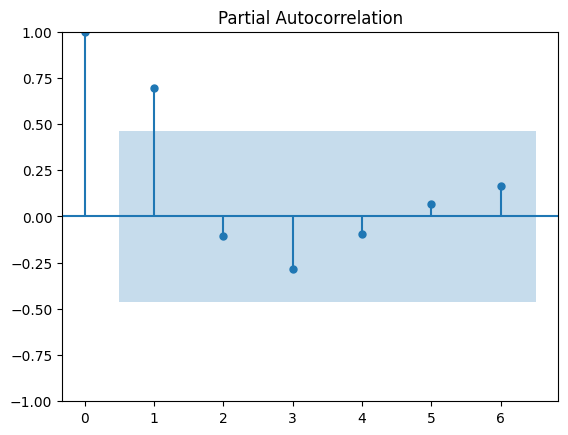


Có tính chu kỳ (seasonality_strength=0.14), nên dùng seasonal=True.


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [155]:
def check_seasonality(time_series, freq=None):
    """
    Kiểm tra xem chuỗi thời gian có tính chu kỳ không.

    Params:
        time_series: Chuỗi dữ liệu dạng pandas Series.
        freq: Tần suất chu kỳ (nếu biết trước, có thể đặt, ví dụ: 12 cho dữ liệu hàng tháng).

    Returns:
        True nếu có seasonality, False nếu không.
    """
    # Handle missing values by filling with the previous valid value (forward fill)
    time_series = time_series.fillna(method='ffill')

    # Bước 1: Phân rã chuỗi thời gian (Seasonal Decomposition)
    decomposition = seasonal_decompose(time_series, period=freq, model='additive', extrapolate_trend='freq')
    seasonal_component = decomposition.seasonal

    # Vẽ thành phần chu kỳ
    plt.figure(figsize=(14, 10))
    plt.subplot(411)
    plt.plot(time_series, label='Original Series')
    plt.legend()
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(seasonal_component, label='Seasonality')
    plt.legend()
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()

    # Bước 2: Kiểm tra ADF Test (Stationarity Test)
    adf_result = adfuller(time_series.dropna())
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")

    if adf_result[1] > 0.05:
        print("Dữ liệu có tính dừng")
    else:
        print("Dữ liệu không có tính dừng")
    print()

    # Bước 3: Kiểm tra Auto-Correlation Function (ACF)
    plot_acf(time_series.dropna(), lags=lags_1)
    plt.show()

    plot_pacf(time_series.dropna(), lags=lags_2)
    plt.show()
    print()

    # Bước 4: Đánh giá độ biến động của thành phần chu kỳ
    seasonality_strength = np.std(seasonal_component) / np.std(time_series)

    if seasonality_strength.item() > 0.1:  # Or seasonality_strength.iloc[0]
        print(f"Có tính chu kỳ (seasonality_strength={seasonality_strength.item():.2f}), nên dùng seasonal=True.")
        return True
    else:
        print(f"Không có tính chu kỳ rõ ràng (seasonality_strength={seasonality_strength.item():.2f}), nên dùng seasonal=False.")
        return False
    print()
# Kiểm tra seasonality
should_use_seasonal = check_seasonality(df, freq=freq) # freq=freq

# BUILDING AN ARIMA MODEL

## Automatically select the best parameters using auto_arima:
auto_arima sẽ tự xử lý differencing nếu dữ liệu có stationarity = false

In [141]:
# Dùng auto_arima để chọn tham số
if should_use_seasonal == True:
  model_auto = auto_arima(df['Sales'], seasonal=True, m=freq, trace=True, suppress_warnings=True, stepwise=True)
else:
  model_auto = auto_arima(df['Sales'], seasonal=False, trace=True, suppress_warnings=True, stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=853.291, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=857.006, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=860.579, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=860.839, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=857.365, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=851.519, Time=4.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=866.121, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=853.369, Time=2.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=863.172, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=854.263, Time=2.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=860.207, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[4] intercept   : AIC=860.406, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,1)[4] intercept   : AIC=851.542, Time=1.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,1)[4] intercept   : AIC=849.239, Time=1.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[4] intercept   : AIC=872.426, Time=6.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[4] intercept   : AIC=inf, Time=3.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,2)[4] intercept   : AIC=873.196, Time=10.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,0)[4] intercept   : AIC=859.199, Time=1.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,2)[4] intercept   : AIC=inf, Time=2.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,1)[4] intercept   : AIC=863.145, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,1)[4] intercept   : AIC=851.147, Time=1.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,1)[4]             : AIC=849.161, Time=0.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[4]             : AIC=inf, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[4]             : AIC=inf, Time=1.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,2)[4]             : AIC=850.895, Time=2.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,0)[4]             : AIC=inf, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,2)[4]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,3)(0,0,1)[4]             : AIC=857.898, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[4]             : AIC=inf, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,1)[4]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,1)[4]             : AIC=859.631, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,1)[4]             : AIC=inf, Time=0.26 sec

Best model:  ARIMA(2,1,3)(0,0,1)[4]          
Total fit time: 53.197 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   18
Model:             SARIMAX(2, 1, 3)x(0, 0, [1], 4)   Log Likelihood                -417.581
Date:                             Wed, 12 Mar 2025   AIC                            849.161
Time:                                     08:06:47   BIC                            854.994
Sample:                                 09-01-2023   HQIC                           849.741
                                      - 02-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

## Training ARIMA model:

In [142]:
# Xây dựng mô hình với tham số từ auto_arima
if should_use_seasonal == True:
  model = SARIMAX(df, order=model_auto.order, seasonal_order=model_auto.seasonal_order)
  model_fit = model.fit()
else:
  model = ARIMA(df, order=model_auto.order)
  model_fit = model.fit()

# Tóm tắt kết quả mô hình
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   18
Model:             SARIMAX(2, 1, 3)x(0, 0, [1], 4)   Log Likelihood                -417.581
Date:                             Wed, 12 Mar 2025   AIC                            849.161
Time:                                     08:06:47   BIC                            854.994
Sample:                                 09-01-2023   HQIC                           849.741
                                      - 02-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5346      0.233     -6.590      0.000      -1.991      -1.078
ar.L2         -0.6282      

# FORECAST AND ASSESSMENT

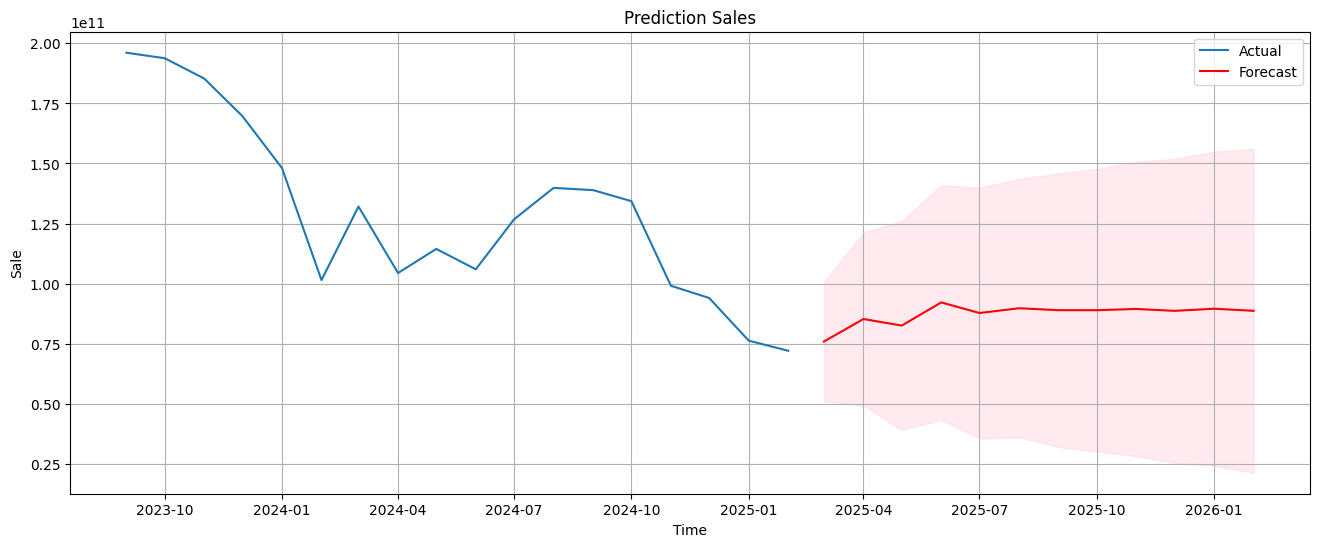


                 Forecast    Lower Bound     Upper Bound
2025-02-01            NaN            NaN             NaN
2025-03-01 75,891,508,048 50,938,156,791 100,844,859,305
2025-04-01 85,258,177,195 49,280,266,540 121,236,087,849
2025-05-01 82,526,489,726 39,067,122,874 125,985,856,578
2025-06-01 92,163,957,716 43,344,775,820 140,983,139,612
2025-07-01 87,755,408,242 35,568,635,264 139,942,181,219
2025-08-01 89,736,470,319 35,963,210,223 143,509,730,414
2025-09-01 88,936,032,194 31,993,554,483 145,878,509,905
2025-10-01 88,920,008,213 30,139,152,859 147,700,863,567
2025-11-01 89,447,394,509 28,164,722,967 150,730,066,052
2025-12-01 88,648,114,435 25,380,515,462 151,915,713,409
2026-01-01 89,543,439,936 24,168,122,356 154,918,757,516
2026-02-01 88,671,509,867 21,286,106,831 156,056,912,903


In [143]:
# Dự báo cho tương lai (12 tháng tiếp theo)
forecast = model_fit.get_forecast(steps=time_step)
df.index = pd.to_datetime(df.index)
forecast_index = pd.date_range(df.index[-1], periods=time_step, freq='MS')  #freq='M' last day of monthly, 'MS' first day of monthly, 'YS' yearly
# forecast_index = np.arange(len(df)+1, len(df) + time_step+1)

# Get the actual column names from the confidence interval DataFrame
conf_int_df = forecast.conf_int()
lower_col = conf_int_df.columns[0]  # Get the name of the lower bound column
upper_col = conf_int_df.columns[1]  # Get the name of the upper bound column

forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower Bound': conf_int_df[lower_col],  # Use the actual lower bound column name
    'Upper Bound': conf_int_df[upper_col]   # Use the actual upper bound column name
}, index=forecast_index)

# Vẽ biểu đồ dự báo
plt.figure(figsize=(16, 6))
plt.plot(df['Sales'], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red') # Explicitly pass the index of forecast_df for the x-axis
plt.fill_between(forecast_df.index,
                 forecast_df['Lower Bound'],
                 forecast_df['Upper Bound'], color='pink', alpha=0.3)
plt.title('Prediction Sales')
plt.xlabel('Time')
plt.ylabel('Sale')
plt.legend()
plt.grid()
plt.show()
print()

print(forecast_df)

# MODEL EVALUATION

In [144]:
# Get forecast values for the specific period
historical_forecast = model_fit.get_prediction(start='2023-10-01', end='2025-02-01')
historical_values = historical_forecast.predicted_mean

# Create a comparison DataFrame for the specific period
comparison_specific = pd.DataFrame({
  'Actual Sales': df['Sales']['2023-10-01':'2025-02-01'],
  'Forecasted Sales': historical_values,
  'Difference': df['Sales']['2023-10-01':'2025-02-01'] - historical_values
})

# Calculate percentage error
comparison_specific['Error %'] = (comparison_specific['Difference'] / comparison_specific['Actual Sales']) * 100

# Format the output
pd.options.display.float_format = '{:,.0f}'.format

print("\nComparison for period 2024-03-01 to 2025-02-01:")
print("===============================================")
print(comparison_specific)

# Calculate metrics for this specific period
mae_specific = mean_absolute_error(comparison_specific['Actual Sales'], comparison_specific['Forecasted Sales'])
rmse_specific = np.sqrt(mean_squared_error(comparison_specific['Actual Sales'], comparison_specific['Forecasted Sales']))

print("\nMetrics for this period:")
print(f"MAE: {mae_specific:,.0f}")
print(f"RMSE: {rmse_specific:,.0f}")


Comparison for period 2024-03-01 to 2025-02-01:
              Actual Sales  Forecasted Sales      Difference  Error %
2023-10-01 193,806,971,443   193,281,534,012     525,437,431        0
2023-11-01 185,357,688,406   192,901,938,533  -7,544,250,127       -4
2023-12-01 169,696,397,949   167,166,811,402   2,529,586,547        1
2024-01-01 148,097,344,016   142,370,522,453   5,726,821,563        4
2024-02-01 101,453,296,824   114,825,201,819 -13,371,904,995      -13
2024-03-01 132,078,849,895   137,663,870,392  -5,585,020,497       -4
2024-04-01 104,406,546,191   108,439,562,789  -4,033,016,598       -4
2024-05-01 114,427,136,014   118,594,825,252  -4,167,689,238       -4
2024-06-01 105,953,337,425   109,375,549,451  -3,422,212,026       -3
2024-07-01 126,744,900,165   112,822,357,757  13,922,542,408       11
2024-08-01 139,829,987,390   126,894,605,670  12,935,381,720        9
2024-09-01 138,905,000,000   139,335,029,539    -430,029,539       -0
2024-10-01 134,309,000,000   140,813,294,

# MODEL DEPLOYMENT

In [145]:
# Lưu mô hình
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

# Tải lại mô hình khi cần
with open('arima_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Dự báo lại với mô hình đã lưu
forecast_loaded = loaded_model.get_forecast(steps=12)
print(forecast_loaded.predicted_mean)

2025-03-01   75,891,508,048
2025-04-01   85,258,177,195
2025-05-01   82,526,489,726
2025-06-01   92,163,957,716
2025-07-01   87,755,408,242
2025-08-01   89,736,470,319
2025-09-01   88,936,032,194
2025-10-01   88,920,008,213
2025-11-01   89,447,394,509
2025-12-01   88,648,114,435
2026-01-01   89,543,439,936
2026-02-01   88,671,509,867
Freq: MS, Name: predicted_mean, dtype: float64


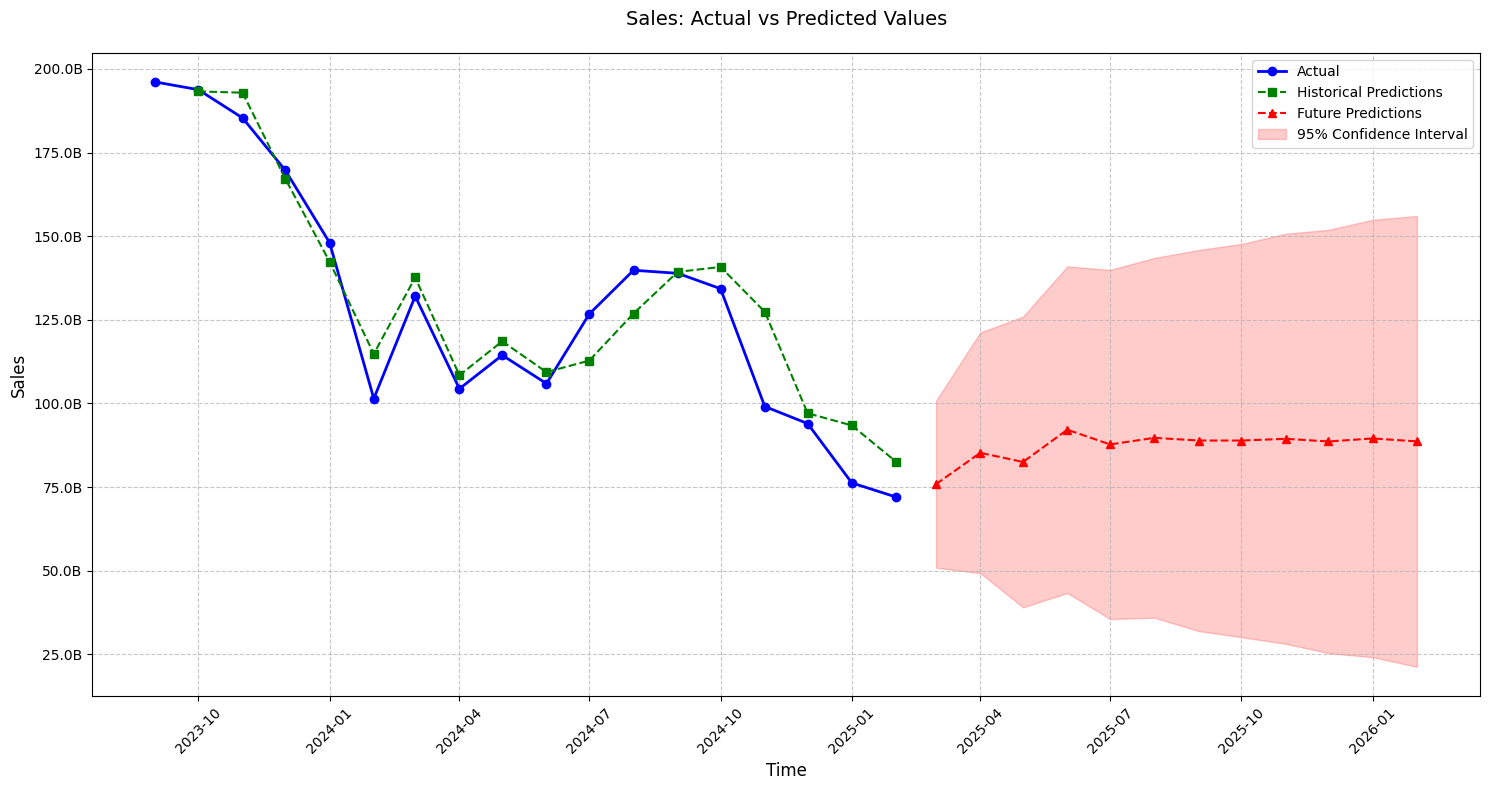

In [146]:
plt.figure(figsize=(15, 8))

# Plot actual values with markers
plt.plot(df.index, df['Sales'],
     label='Actual',
     marker='o',
     color='blue',
     linewidth=2,
     markersize=6)

# Plot predicted values for the historical period
plt.plot(historical_values.index, historical_values,
     label='Historical Predictions',
     color='green',
     linestyle='--',
     marker='s',
     markersize=6)

# Plot future predictions
plt.plot(forecast_df.index, forecast_df['Forecast'],
     label='Future Predictions',
     color='red',
     linestyle='--',
     marker='^',
     markersize=6)

# Add confidence intervals for future predictions
plt.fill_between(forecast_df.index,
         forecast_df['Lower Bound'],
         forecast_df['Upper Bound'],
         color='red',
         alpha=0.2,
         label='95% Confidence Interval')

# Customize the plot
plt.title('Sales: Actual vs Predicted Values', fontsize=14, pad=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Format y-axis to billions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [147]:
# Create a complete comparison DataFrame
comparison_df = pd.DataFrame({
  'Actual Sales': df['Sales'],
  'Forecasted Sales': historical_values,  # historical_values already has correct index
  'Lower Bound': None,  # Initialize with None
  'Upper Bound': None   # Initialize with None
})

# Add future predictions
future_predictions = pd.DataFrame({
  'Actual Sales': None,  # Create a list of None values with the same length as forecast_df
  'Forecasted Sales': forecast_df['Forecast'].dropna(),
  'Lower Bound': forecast_df['Lower Bound'].dropna(),
  'Upper Bound': forecast_df['Upper Bound'].dropna()
}, index=forecast_df.index[1:])

# Combine historical and future data
comparison_df = pd.concat([comparison_df, future_predictions])

# Calculate error metrics for historical data where we have both actual and predicted values
mask = comparison_df['Actual Sales'].notna() & comparison_df['Forecasted Sales'].notna()
comparison_df.loc[mask, 'Absolute Error'] = abs(
  comparison_df.loc[mask, 'Actual Sales'] -
  comparison_df.loc[mask, 'Forecasted Sales']
)
comparison_df.loc[mask, 'Percentage Error'] = (
  (comparison_df.loc[mask, 'Actual Sales'] -
   comparison_df.loc[mask, 'Forecasted Sales']) /
  comparison_df.loc[mask, 'Actual Sales'] * 100
)

# Format numbers for better readability
pd.options.display.float_format = '{:,.0f}'.format

print("\nComplete Comparison Table:")
print("=========================")
print(comparison_df.dropna)
print()

print("\nMetrics for this period:")
print(f"MAE: {mae_specific:,.0f}")
print(f"RMSE: {rmse_specific:,.0f}")


Complete Comparison Table:
<bound method DataFrame.dropna of               Actual Sales  Forecasted Sales    Lower Bound     Upper Bound  Absolute Error  Percentage Error
2023-09-01 196,088,478,048               NaN            NaN             NaN             NaN               NaN
2023-10-01 193,806,971,443   193,281,534,012            NaN             NaN     525,437,431                 0
2023-11-01 185,357,688,406   192,901,938,533            NaN             NaN   7,544,250,127                -4
2023-12-01 169,696,397,949   167,166,811,402            NaN             NaN   2,529,586,547                 1
2024-01-01 148,097,344,016   142,370,522,453            NaN             NaN   5,726,821,563                 4
2024-02-01 101,453,296,824   114,825,201,819            NaN             NaN  13,371,904,995               -13
2024-03-01 132,078,849,895   137,663,870,392            NaN             NaN   5,585,020,497                -4
2024-04-01 104,406,546,191   108,439,562,789            Na

<ipython-input-147-5777de7ef4ea>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_df = pd.concat([comparison_df, future_predictions])
